In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.src.utils import image_dataset_from_directory
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.proportion import proportion_confint
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Input, BatchNormalization
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.models import Sequential, Model

In [2]:
RANDOM_SEED = 2_055
IMG_SIZE = (200, 200, 3)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def compile_fit_model(train, validation, learning_rate: float, batch_size: int,
                      batch_normalization: False) -> Sequential:
    model = Sequential()

    # First convolutional block
    model.add(Input(shape=IMG_SIZE))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional block
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth convolutional block
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Transform convolutional block to a vector
    model.add(GlobalAveragePooling2D())

    # Dense hidden layer
    model.add(Dense(32, activation='relu'))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'recall',
            TruePositives(name='tp'),
            TrueNegatives(name='tn'),
            FalsePositives(name='fp'),
            FalseNegatives(name='fn'),
        ]
    )

    history = model.fit(train, validation_data=validation, epochs=5, batch_size=batch_size, verbose=False)

    return model, history

In [4]:
# Define paths
base_dir = './../data/face_age_reduced'
train_dir = base_dir

train_dataset = image_dataset_from_directory(
    base_dir,
    validation_split=.2,
    subset="training",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE
)

validation_dataset = image_dataset_from_directory(
    base_dir,
    validation_split=.2,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE
)

train_ds = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# check the class names
class_names = train_dataset.class_names
print(class_names)

Found 100 files belonging to 2 classes.
Using 80 files for training.
Found 100 files belonging to 2 classes.
Using 20 files for validation.
['adult', 'minor']


# Model training

**Model 1**
- Learning rate: 0.01
- Batch normalization: False
- Batch size: 32

In [5]:
model_1, history_1 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.01, batch_normalization=False, batch_size=32
)

**Model 2**
- Learning rate: 0.005
- Batch normalization: False
- Batch size: 32

In [6]:
model_2, history_2 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.005, batch_normalization=False, batch_size=32
)

**Model 3**
- Learning rate: 0.001
- Batch normalization: False
- Batch size: 32

In [7]:
model_3, history_3 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.001, batch_normalization=False, batch_size=32
)

**Model 4**
- Learning rate: 0.01
- Batch normalization: True
- Batch size: 32

In [8]:
model_4, history_4 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.01, batch_normalization=True, batch_size=32
)

**Model 5**
- Learning rate: 0.005
- Batch normalization: True
- Batch size: 32

In [9]:
model_5, history_5 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.005, batch_normalization=True, batch_size=32
)

**Model 6**
- Learning rate: 0.001
- Batch normalization: True
- Batch size: 32

In [10]:
model_6, history_6 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.001, batch_normalization=True, batch_size=32
)

**Model 7**
- Learning rate: 0.01
- Batch normalization: False
- Batch size: 64

In [11]:
model_7, history_7 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.01, batch_normalization=False, batch_size=64
)

**Model 8**
- Learning rate: 0.005
- Batch normalization: False
- Batch size: 64

In [12]:
model_8, history_8 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.005, batch_normalization=False, batch_size=64
)

**Model 9**
- Learning rate: 0.001
- Batch normalization: False
- Batch size: 64

In [13]:
model_9, history_9 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.001, batch_normalization=False, batch_size=64
)

**Model 10**
- Learning rate: 0.01
- Batch normalization: True
- Batch size: 64

In [14]:
model_10, history_10 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.01, batch_normalization=True, batch_size=64
)

**Model 11**
- Learning rate: 0.005
- Batch normalization: True
- Batch size: 64

In [15]:
model_11, history_11 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.005, batch_normalization=True, batch_size=64
)

**Model 12**
- Learning rate: 0.001
- Batch normalization: True
- Batch size: 64

In [16]:
model_12, history_12 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.001, batch_normalization=True, batch_size=64
)

In [17]:
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10, model_11, model_12]
histories = [history_1, history_2, history_3, history_4, history_5, history_6, history_7, history_8, history_9,
             history_10, history_11, history_12]

In [18]:
def plot_losses_and_metrics(history, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    axs[0].plot(history.history['loss'], label=f"train {history.history['loss'][-1]:.2f}", color="#003B80",
                linestyle="dotted")
    axs[0].plot(history.history['val_loss'], label=f"validation {history.history['val_loss'][-1]:.2f}", color="#003B80")

    axs[0].set_title('Loss', color='#003B80', fontsize=14)

    axs[0].set_xlabel('Epoch', color='#003B80')
    axs[0].xaxis.set_major_locator(MultipleLocator(1))

    axs[0].set_ylabel('Loss', color='#003B80')
    axs[0].set_ylim(ymin=0, ymax=1.1)
    axs[0].yaxis.set_major_locator(MultipleLocator(0.1))

    axs[0].set_facecolor("#E3F7FA")
    axs[0].grid(visible=True, which='major', axis='both', color='white')
    axs[0].set_axisbelow(True)
    axs[0].legend()

    # Plot metrics (sensitivity, specificity)
    specificity = np.array(history.history['tn']) / (np.array(history.history['tn']) + np.array(history.history['fp']))
    val_specificity = np.array(history.history['val_tn']) / (
            np.array(history.history['val_tn']) + np.array(history.history['val_fp']))

    axs[1].plot(history.history['recall'], label=f"sensitivity train {history.history['recall'][-1]:.2f}",
                color="#003B80",
                linestyle="dotted")
    axs[1].plot(history.history['val_recall'], label=f"sensitivity validation {history.history['val_recall'][-1]:.2f}",
                color="#003B80")
    axs[1].plot(specificity, label=f"specificity train {specificity[-1]:.2f}", color="#FFA500", linestyle="dotted")
    axs[1].plot(val_specificity, label=f"specificity validation {val_specificity[-1]:.2f}", color="#FFA500")

    axs[1].set_title('Metrics', color='#003B80', fontsize=14)

    axs[1].set_xlabel('Epoch', color='#003B80')
    axs[1].xaxis.set_major_locator(MultipleLocator(1))

    axs[1].set_ylabel('Metric value', color='#003B80')
    axs[1].set_ylim(ymin=0, ymax=1.1)
    axs[1].yaxis.set_major_locator(MultipleLocator(0.1))

    axs[1].set_facecolor("#E3F7FA")
    axs[1].grid(visible=True, which='major', axis='both', color='white')
    axs[1].set_axisbelow(True)
    axs[1].legend()

    fig.suptitle(title, fontsize=18, color='#003B80')
    return fig


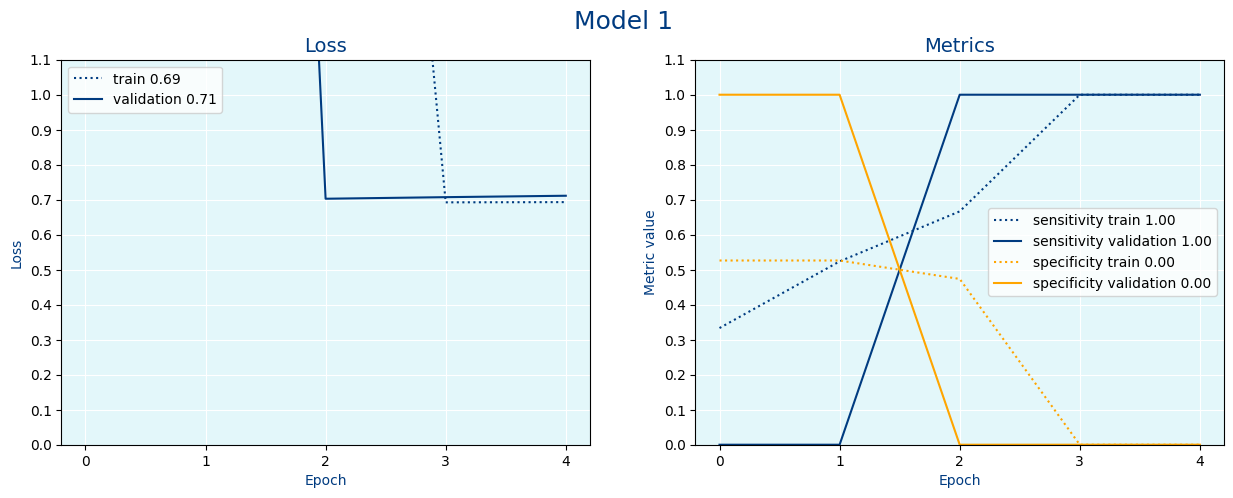

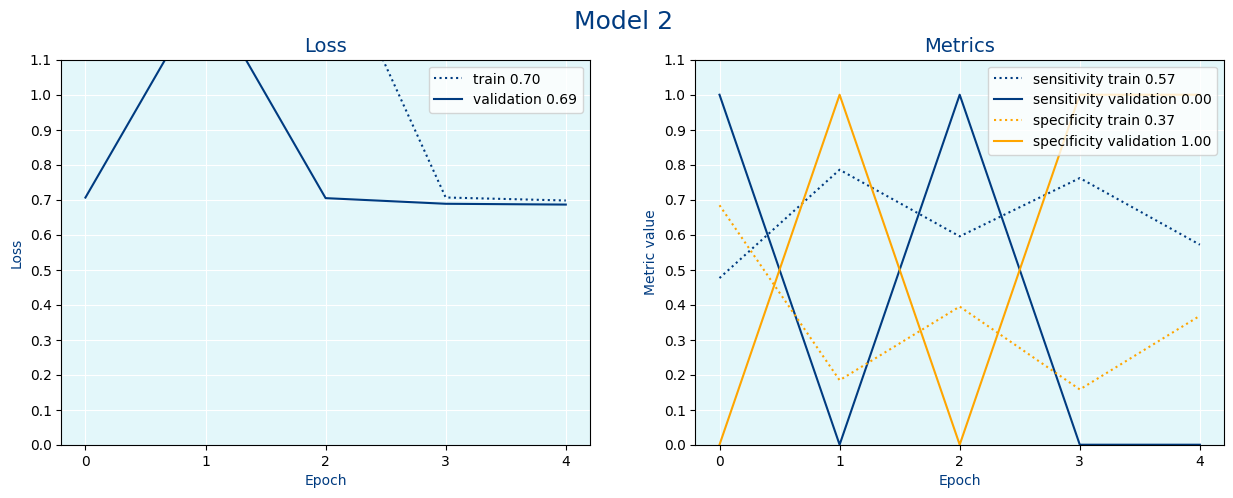

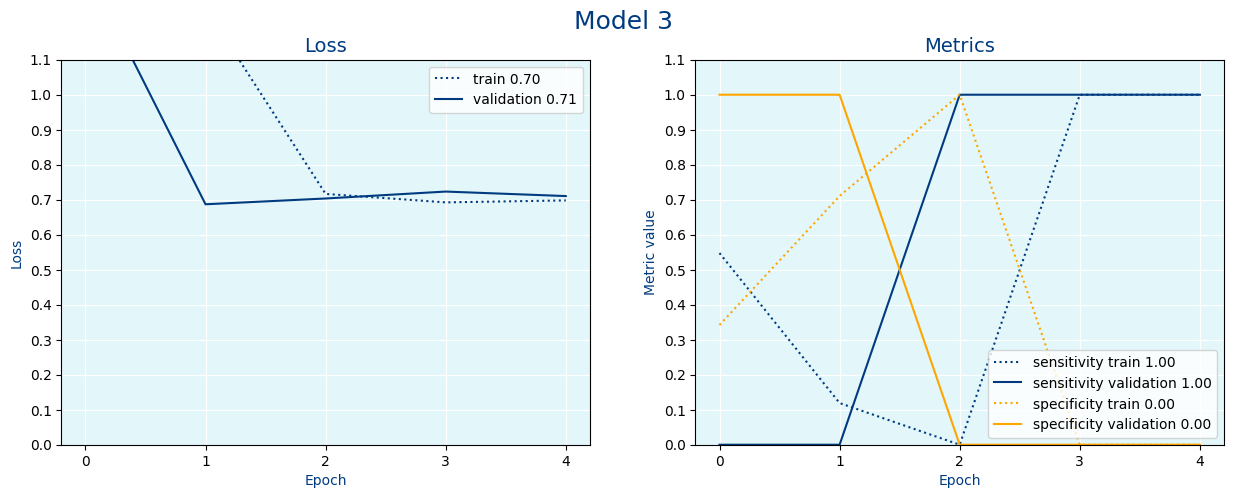

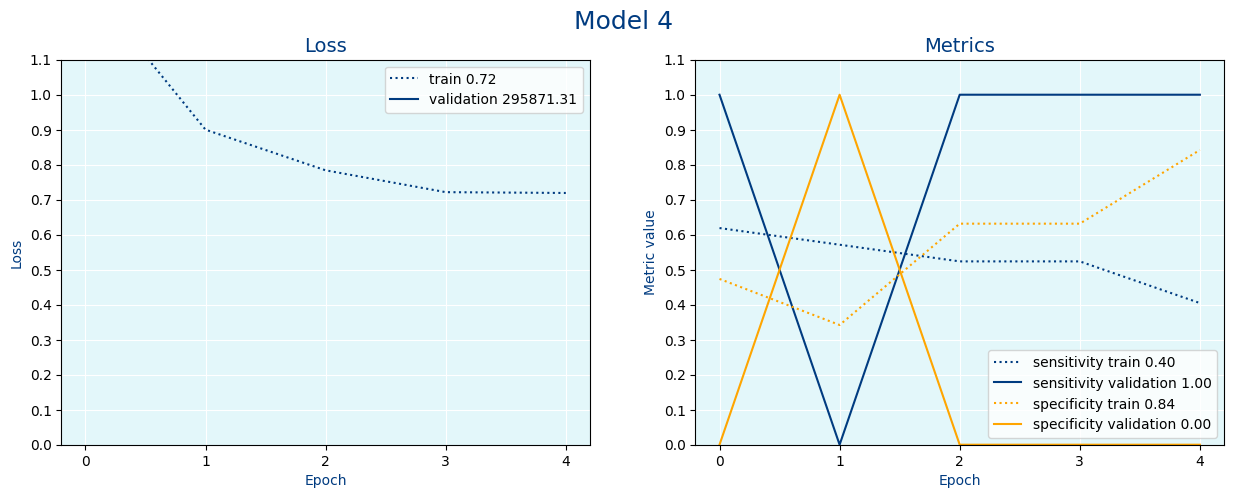

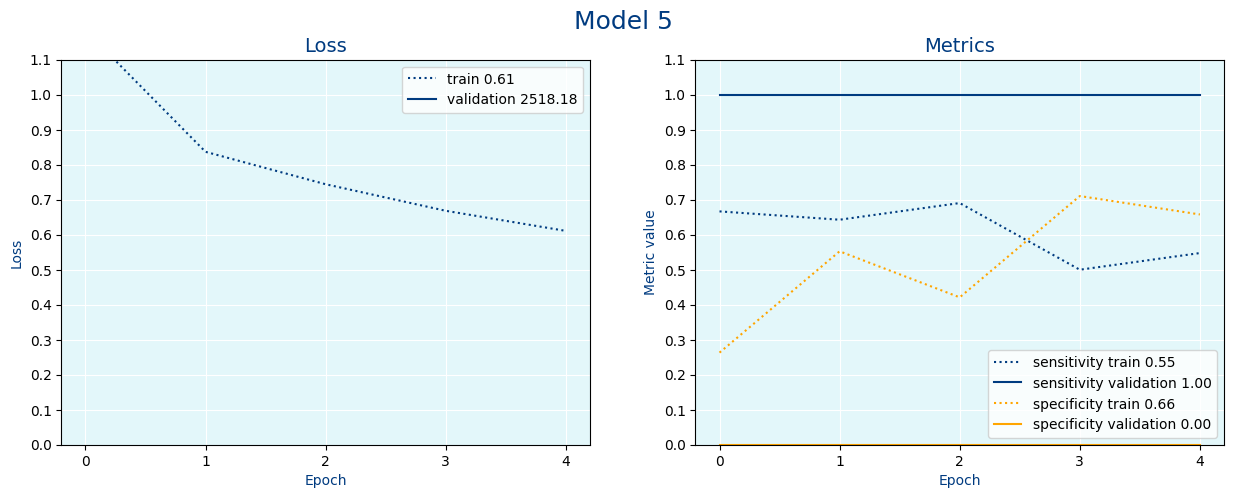

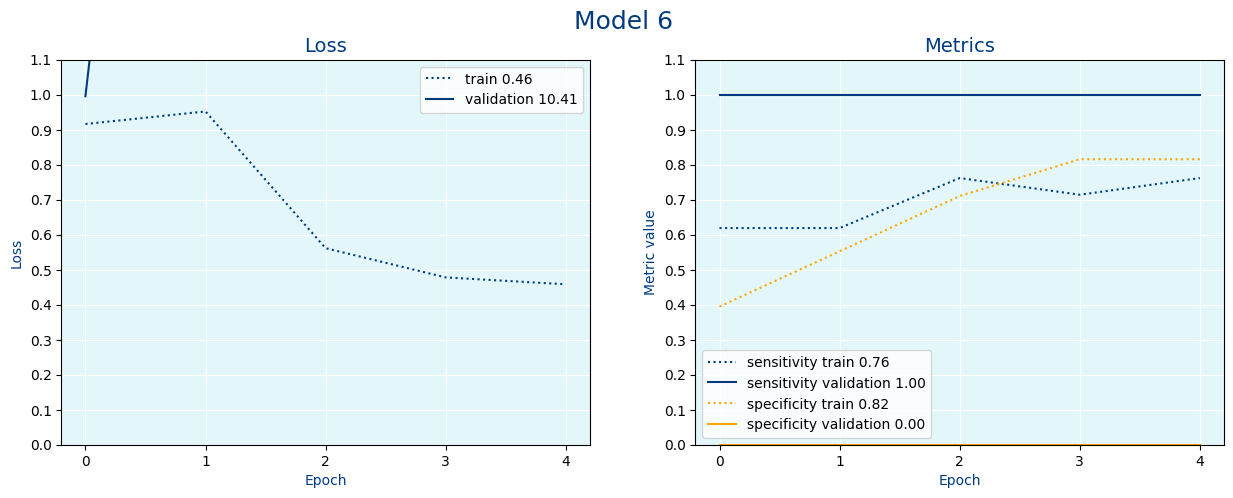

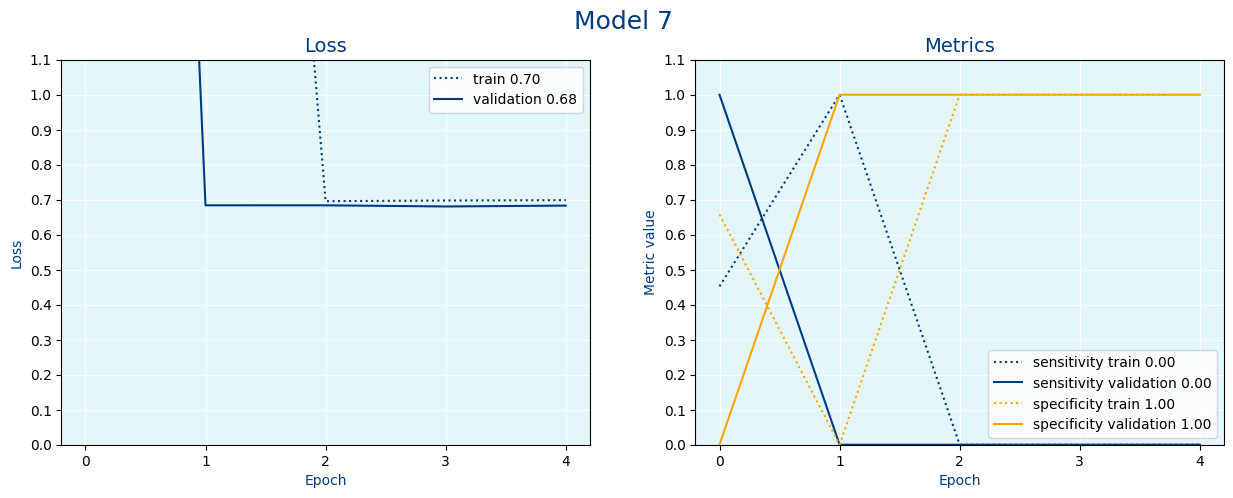

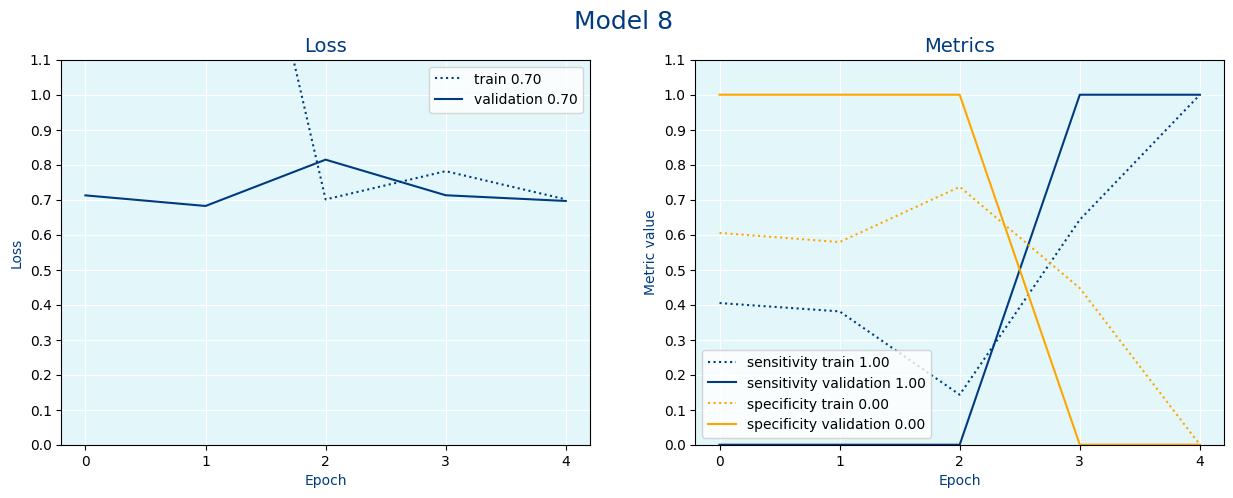

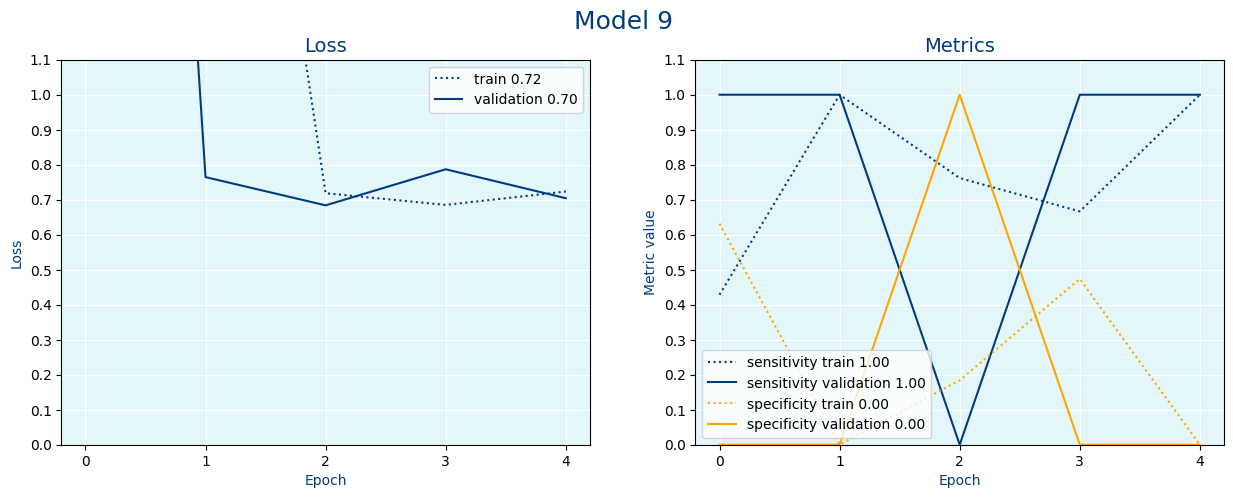

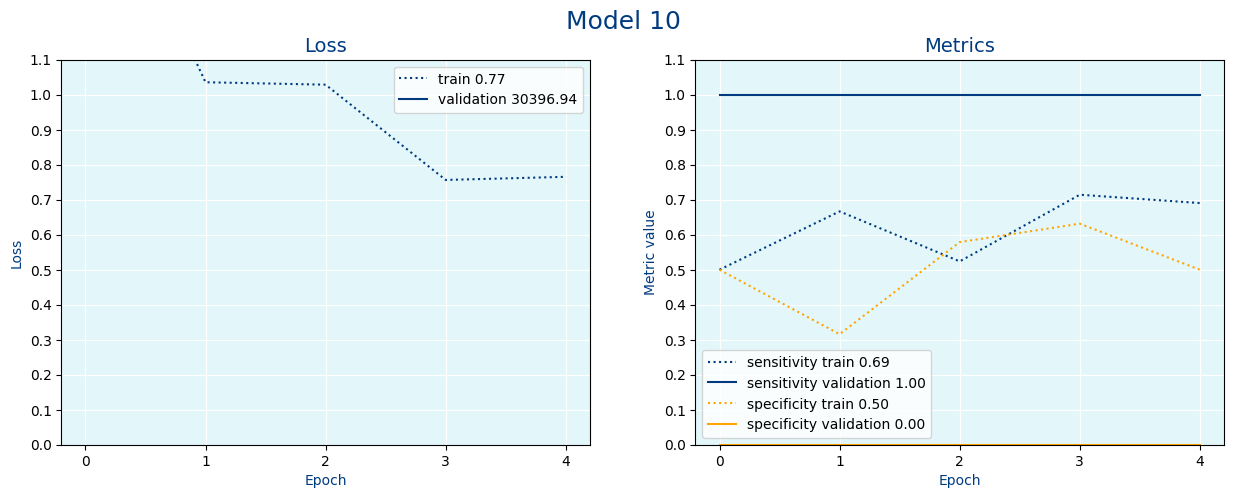

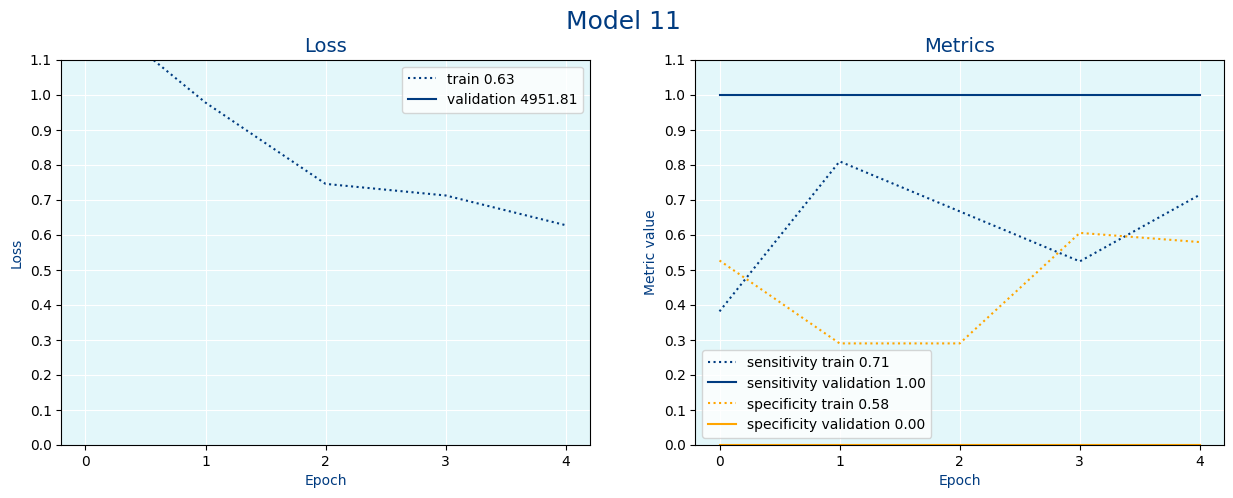

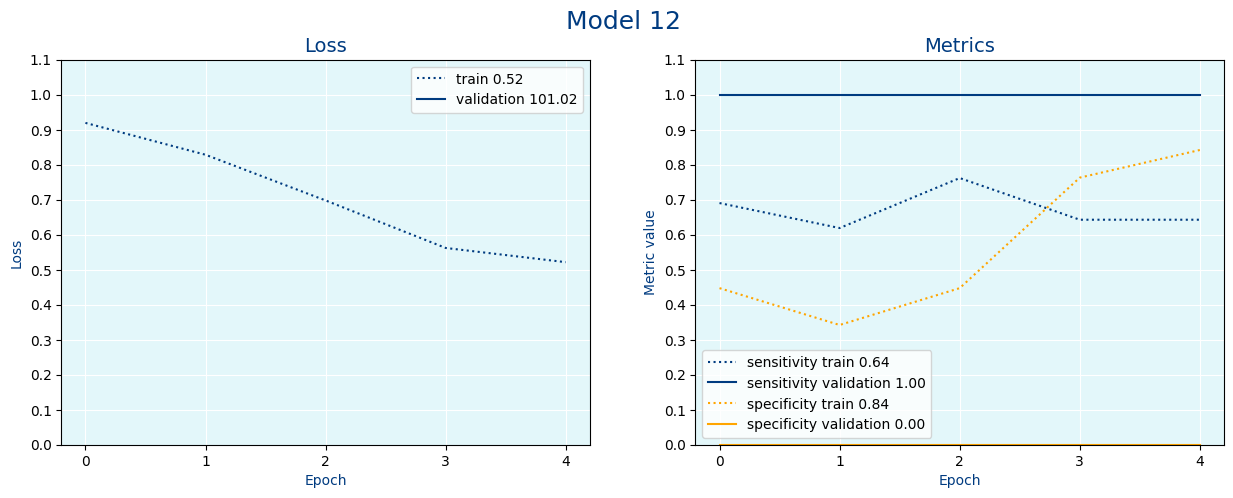

In [19]:
for idx, history in enumerate(histories):
    fig = plot_losses_and_metrics(history, f'Model {idx + 1}')

In a graph, shows for all models and the best epoch; the sensitivity metric with the confidence interval.

In [20]:
def plot_intervals(axes, intervalos, title, xlabel, ylabels):
    for index, (inferior, superior) in enumerate(intervalos):
        position = len(intervalos) - index - 1
        average = ((superior - inferior) / 2) + inferior
        axes.plot([inferior, superior], [position, position], marker='|', markersize=10, linestyle='-')
        axes.scatter(average, position)

    axes.set_yticks(np.arange(len(ylabels)))
    axes.set_yticklabels(ylabels[::-1])
    axes.set_xlabel(xlabel)
    axes.set_title(title)

    axes.set_facecolor("#F0F7FF")
    axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=1)

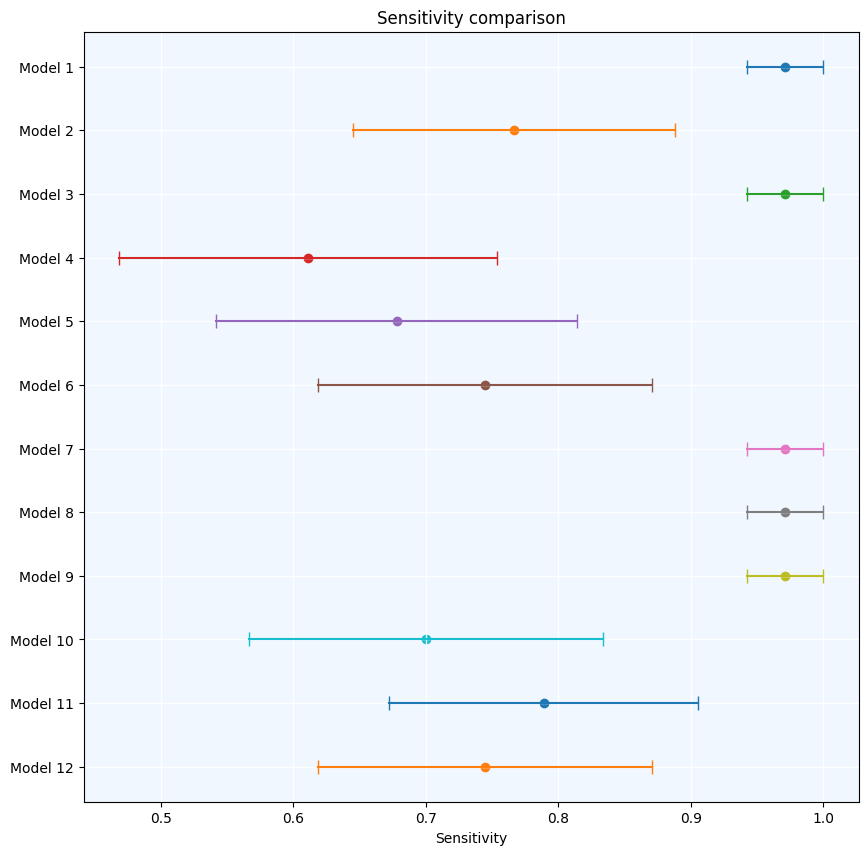

In [21]:
figure = plt.figure(figsize=(10, 10))
axes = figure.add_subplot()

confidence_intervals = []
for history in histories:
    tp = np.array(history.history['tp'])
    fn = np.array(history.history['fn'])
    # FIXME: All validation metrics cover the whole range
    # tp = np.array(history.history['val_tp'])
    # fn = np.array(history.history['val_fn'])
    specificity = tp / (tp + fn)
    best_epoch = np.argmax(specificity)
    lower, upper = proportion_confint(tp[best_epoch], tp[best_epoch] + fn[best_epoch], alpha=0.05, method='jeffreys')
    confidence_intervals.append((lower, upper))

y_labels = [f'Model {i + 1}' for i in range(12)]

plot_intervals(axes, confidence_intervals, 'Sensitivity comparison', 'Sensitivity', y_labels)

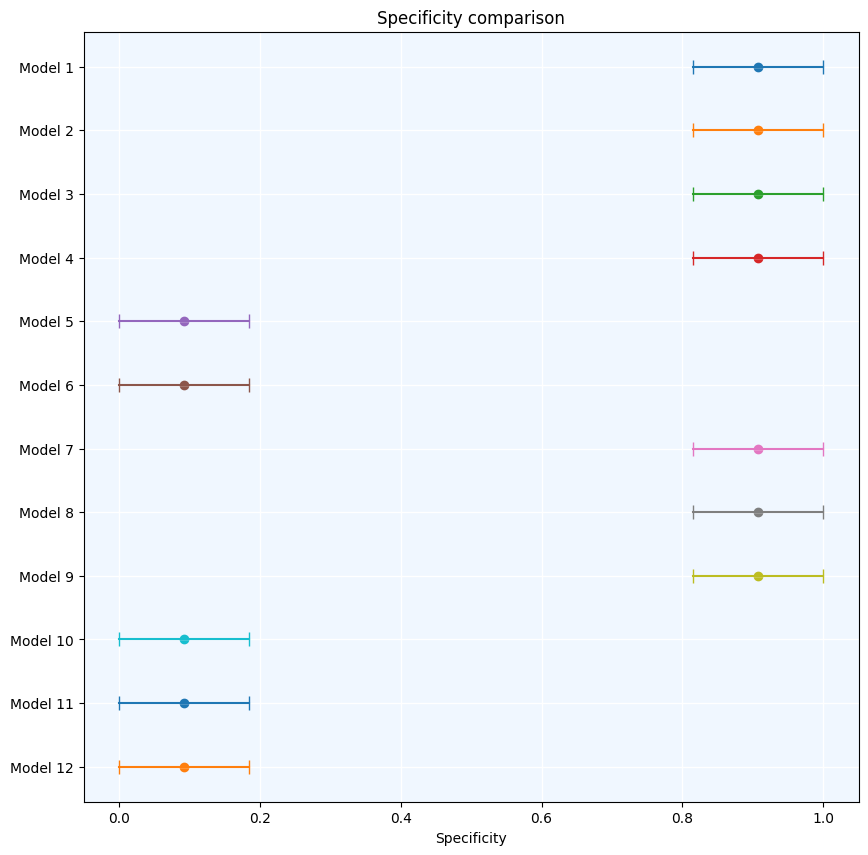

In [22]:
figure = plt.figure(figsize=(10, 10))
axes = figure.add_subplot()

confidence_intervals = []
for history in histories:
    tn = np.array(history.history['val_tn'])
    fp = np.array(history.history['val_fp'])
    specificity = tn / (tn + fp)
    best_epoch = np.argmax(specificity)
    lower, upper = proportion_confint(tn[best_epoch], tn[best_epoch] + fp[best_epoch], alpha=0.05, method='jeffreys')
    confidence_intervals.append((lower, upper))

y_labels = [f'Model {i + 1}' for i in range(12)]

plot_intervals(axes, confidence_intervals, 'Specificity comparison', 'Specificity', y_labels)

# Model choice

In order to choose the best model, we will focus on the sensitivity metric. The main reasons to choose this method are:
- The metric is independent of the prevalence and, for our problem, this is specially important since the train dataset is unbalanced towards more adult picture but in production, it will be unbalanced towards more minor pictures.
- It is important to maximize the number of true positives to avoid minors appear in the import. Even if this could cause more false negatives, it will always be better to pixelate out an adult from the picture rather than not pixelating a minor.

The model that gives the best results is model 6.

In [23]:
best_model = model_6

Train the model more epochs, until there is no improvement in the validation loss

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

best_model_history = best_model.fit(train_ds, validation_data=validation_ds, epochs=100, batch_size=32, verbose=False,
                                    callbacks=[early_stopping])

In [25]:
thresholds = np.linspace(0, 1, 100)

sensitivities = []
specificities = []

y_scores = best_model.predict(validation_ds, verbose=False)
y_true = np.concatenate([y for x, y in validation_ds], axis=0)

for threshold in thresholds:
    y_pred = y_scores > threshold

    tp = np.sum(y_pred & y_true)
    fn = np.sum(~y_pred & y_true)
    tn = np.sum(~y_pred & ~y_true)
    fp = np.sum(y_pred & ~y_true)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    sensitivities.append(sensitivity)
    specificities.append(specificity)


In [26]:
def plot_threshold_vs_metrics(thresholds, sensitivities, specificities):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(thresholds, sensitivities, label='Sensitivity', color='#003B80')
    ax.plot(thresholds, specificities, label='Specificity', color='#FFA500')

    ax.set_title('Threshold vs Sensitivity and Specificity', fontsize=14, color='#003B80')
    ax.set_xlabel('Threshold', color='#003B80')
    ax.set_ylabel('Metric value', color='#003B80')

    ax.set_facecolor("#E3F7FA")
    ax.grid(visible=True, which='major', axis='both', color='white')
    ax.set_axisbelow(True)
    ax.legend()

    return fig

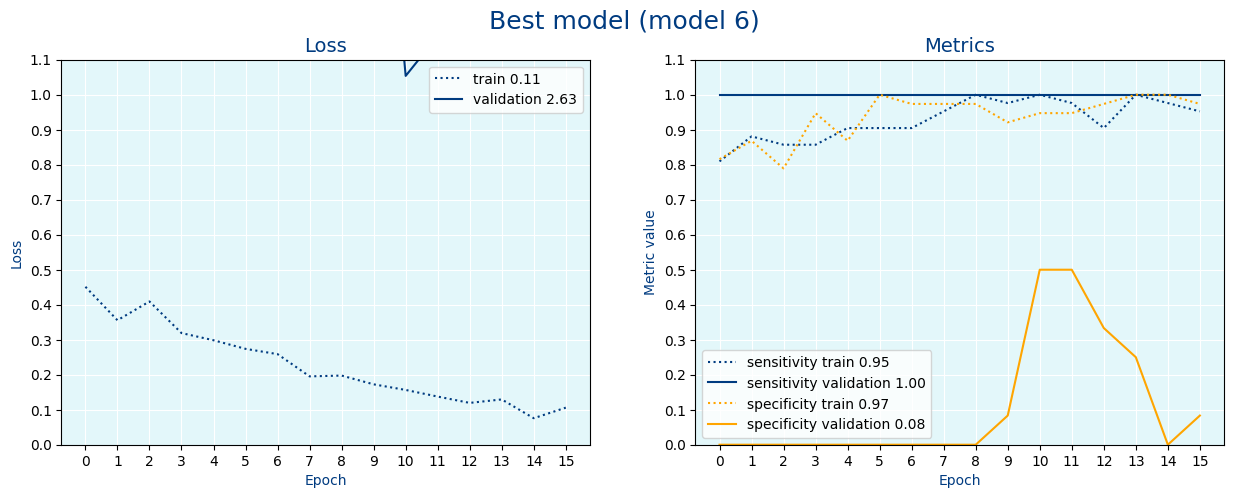

In [27]:
_ = plot_losses_and_metrics(best_model_history, 'Best model (model 6)')

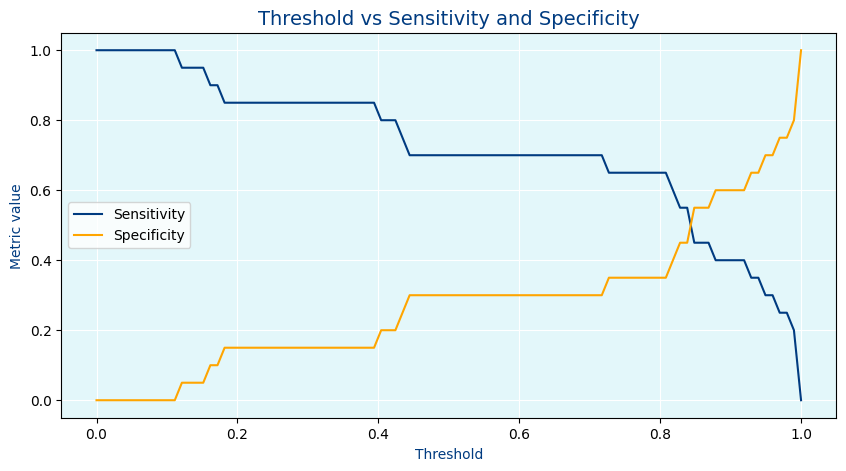

In [28]:
_ = plot_threshold_vs_metrics(thresholds, sensitivities, specificities)

The best threshold for our problem will be around 0.1, as explained above, we want to maximize the number of true positives so there are no minors in the final picture. This threshold has almost the highest sensitivity, and even if the specificity is rather low, it is not our main goal.

In [29]:
best_threshold_model = 0.1

y_scores = best_model.predict(validation_ds, verbose=False)
y_pred = y_scores > best_threshold_model

tp = np.sum(y_pred & y_true)
fn = np.sum(~y_pred & y_true)
tn = np.sum(~y_pred & ~y_true)
fp = np.sum(y_pred & ~y_true)

best_sensitivity_interval = proportion_confint(tp, tp + fn, alpha=0.05, method='jeffreys')
best_specificity_interval = proportion_confint(tn, tn + fp, alpha=0.05, method='jeffreys')

Now you are going to re-create the model using knowledge transfer. For this you use the pre-trained MobileNetV2 model. To perform knowledge transfer, you have to perform the phases of both feature extraction and fine tuning. 

**Feature extraction**

In [30]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE))
base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

input = layers.Input(shape=IMG_SIZE)

x = preprocess_input(input)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model_transfer_knowledge = Model(inputs=[input], outputs=[output])

model_transfer_knowledge.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'recall',
        TruePositives(name='tp'),
        TrueNegatives(name='tn'),
        FalsePositives(name='fp'),
        FalseNegatives(name='fn'),
    ]
)

history_transfer_knowledge = model_transfer_knowledge.fit(train_ds, validation_data=validation_ds, epochs=5,
                                                          batch_size=32, verbose=False)

C:\Users\jsanchez\AppData\Local\Temp\ipykernel_22060\1848209071.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE))


**Fine tuning**

In [31]:
# TODO: probar a hacer el fine tuning entero
base_model.trainable = True

fine_tuning_layer = 100
for layer in base_model.layers[:fine_tuning_layer]:
    layer.trainable = False

model_transfer_knowledge.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'recall',
        TruePositives(name='tp'),
        TrueNegatives(name='tn'),
        FalsePositives(name='fp'),
        FalseNegatives(name='fn'),
    ]
)

history_fine_tuning = model_transfer_knowledge.fit(train_ds, validation_data=validation_ds, epochs=100, batch_size=32,
                                                   verbose=False, callbacks=[early_stopping])

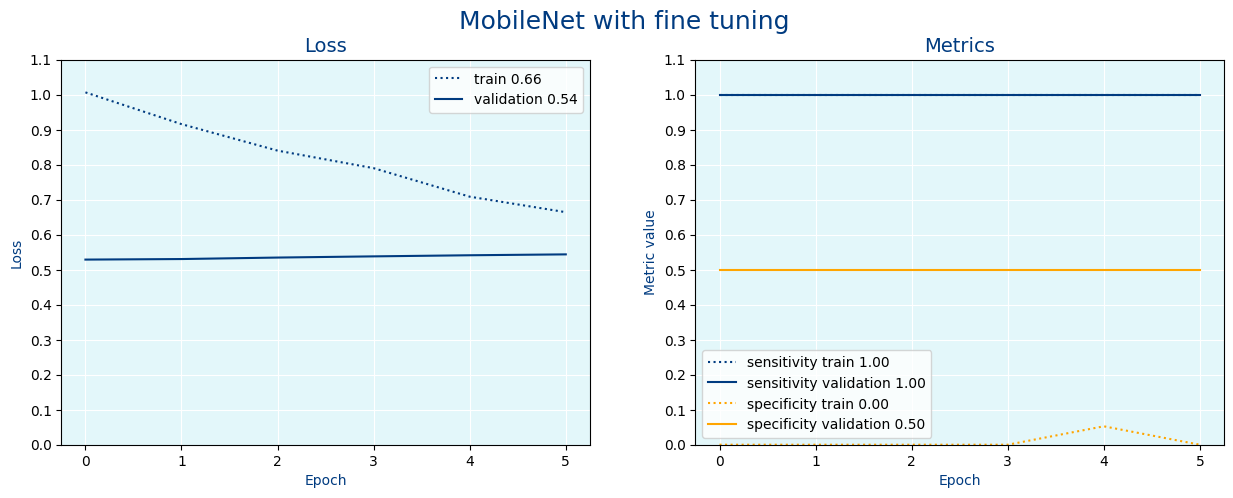

In [32]:
_ = plot_losses_and_metrics(history_fine_tuning, 'MobileNet with fine tuning')

In [33]:
thresholds_mobilenet = np.linspace(0, 1, 100)

sensitivities_mobilenet = []
specificities_mobilenet = []

y_scores_mobilenet = model_transfer_knowledge.predict(validation_ds, verbose=False)
y_true = np.concatenate([y for x, y in validation_ds], axis=0)

for threshold in thresholds_mobilenet:
    y_pred = y_scores_mobilenet > threshold

    tp = np.sum(y_pred & y_true)
    fn = np.sum(~y_pred & y_true)
    tn = np.sum(~y_pred & ~y_true)
    fp = np.sum(y_pred & ~y_true)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    sensitivities_mobilenet.append(sensitivity)
    specificities_mobilenet.append(specificity)

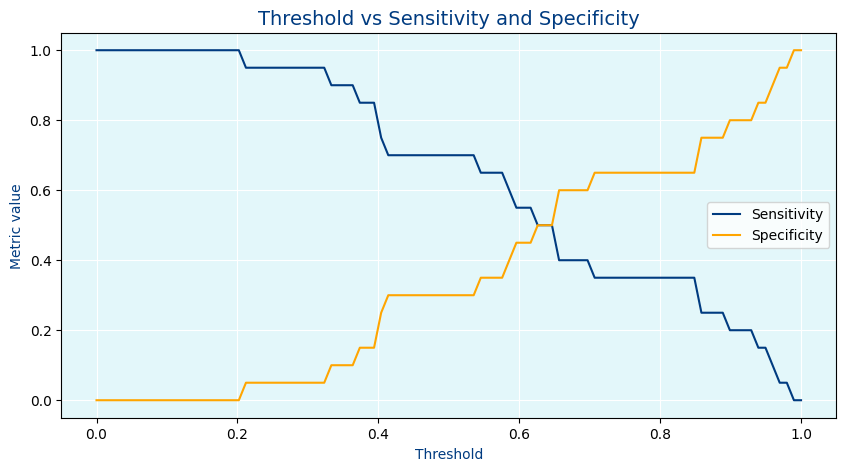

In [34]:
_ = plot_threshold_vs_metrics(thresholds_mobilenet, sensitivities_mobilenet, specificities_mobilenet)

The best threshold for our problem will be around 0.3 for the reasons explained above in the previous model.

In [35]:
best_threshold_mobilenet_model = 0.3

y_pred = y_scores_mobilenet > best_threshold_mobilenet_model

tp = np.sum(y_pred & y_true)
fn = np.sum(~y_pred & y_true)
tn = np.sum(~y_pred & ~y_true)
fp = np.sum(y_pred & ~y_true)

best_mobilenet_sensitivity_interval = proportion_confint(tp, tp + fn, alpha=0.05, method='jeffreys')
best_mobilenet_specificity_interval = proportion_confint(tn, tn + fp, alpha=0.05, method='jeffreys')

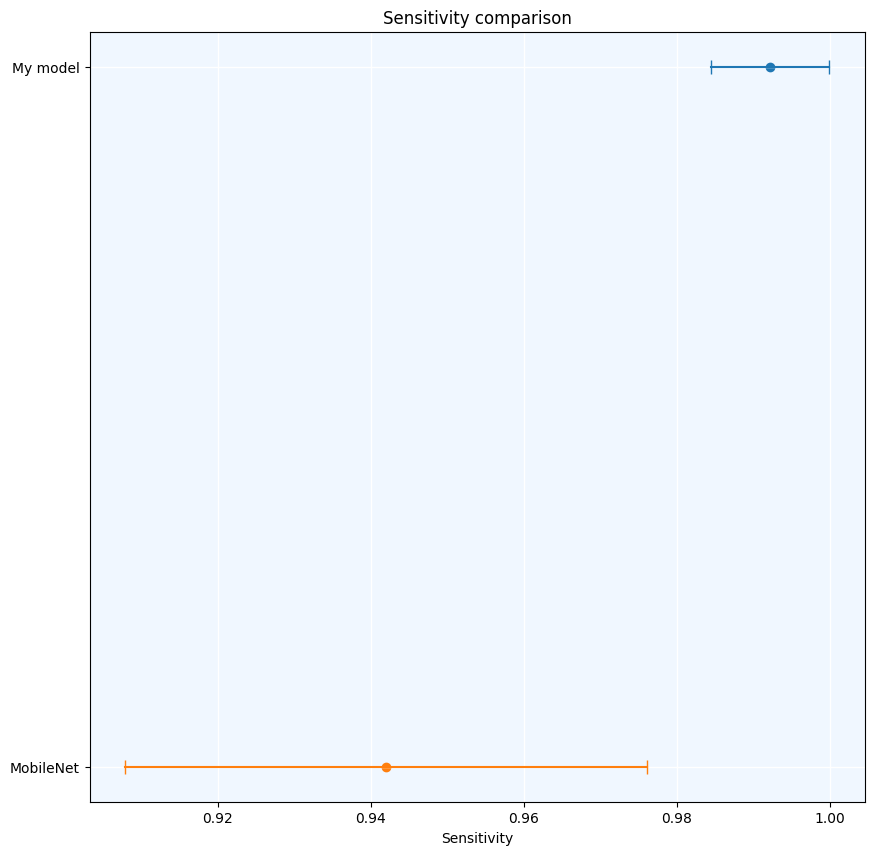

In [36]:
figure = plt.figure(figsize=(10, 10))
axes = figure.add_subplot()

plot_intervals(
    axes,
    [best_sensitivity_interval, best_mobilenet_sensitivity_interval],
    'Sensitivity comparison',
    'Sensitivity',
    ['My model', 'MobileNet']
)

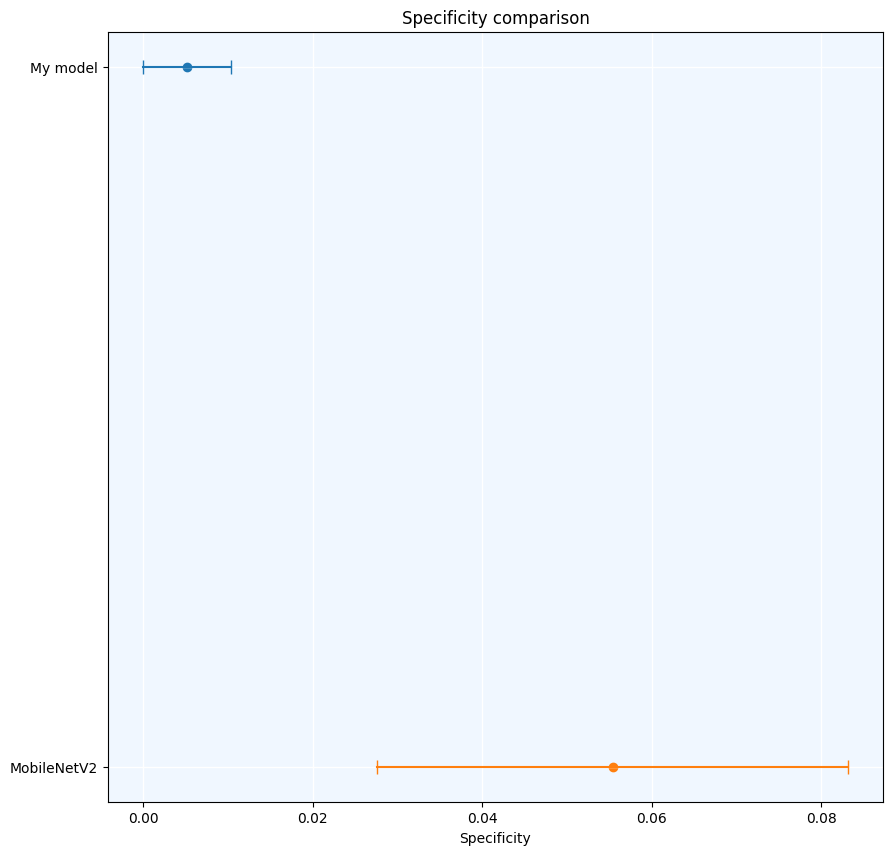

In [37]:
figure = plt.figure(figsize=(10, 10))
axes = figure.add_subplot()

plot_intervals(
    axes,
    [best_specificity_interval, best_mobilenet_specificity_interval],
    'Specificity comparison',
    'Specificity',
    ['My model', 'MobileNetV2']
)